# Running Dask on AzureML

This notebook shows how to run a Dask cluster on an AzureML Compute cluster. 
For setup instructions of you python environment, please see the [Readme](../README.md)

## 1. Starting the cluster

In [1]:
from azureml.core import Workspace, Experiment
from azureml.train.estimator import Estimator
from azureml.widgets import RunDetails
from azureml.core.runconfig import MpiConfiguration
from azureml.core import VERSION
import uuid
import time

VERSION

'1.13.0'

In [2]:
# to load the workspace from configuration file
ws = Workspace.from_config()   

In [3]:
# select the compute target named "dask-resources" in this workspace to run the script 
dask_cluster = ws.compute_targets['dask-resources']

Starting the Dask cluster using an Estimator with MpiConfiguration. The `Estimator` class wraps run configuration information to help simplify the task of specifying how a script is executed. The parameter `compute_target` is the compute target where training will happen. This can either be an object or the string "local". `entry_script` is the relative path to the file used to start training. `script_params` is a dictionary of command-line arguments to pass to the training script specified in entry_script. `node_count` is the number of nodes in the compute target used for training. If greater than 1, an MPI distributed job will be run. `MPI`, Message Passing Interface (MPI) is a communication protocol for parallel programming. MPI is specifically used to allow applications to run in parallel across a number of separate computers connected by a network. It can run 

In [4]:
# start the dask cluster 
est = Estimator('dask',  # Local directory that contains all of your code needed for the training job. This folder gets copied from your local machine to the remote compute.
                compute_target=dask_cluster,  
                entry_script='startDask.py',  
                conda_dependencies_file='environment.yml', 
                script_params={'--datastore': ws.get_default_datastore()},  
                node_count=1,  
                distributed_training=MpiConfiguration())

# create an experiment named 'dask_experiment' from the workspace and submit the experiment to AzureML cluster
run = Experiment(ws, 'dask_experiment_new').submit(est)

WARNING - If 'script' has been provided here and a script file name has been specified in 'run_config', 'script' provided in ScriptRunConfig initialization will take precedence.
WARNING - If 'arguments' has been provided here and arguments have been specified in 'run_config', 'arguments' provided in ScriptRunConfig initialization will take precedence.


In [5]:
# RunDetails class represents a Jupyter notebook widget used to view the progress of model training.
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

## 2. Establish the port-forwarding from Notebook VM to Dask Scheduler

In [10]:
# get the headnode private ip
from IPython.display import clear_output

print("waiting for scheduler node's ip")
while not 'headnode' in run.get_metrics():
    print('.', end ="")
    time.sleep(5)

clear_output()
headnode_private_ip = run.get_metrics()['headnode']
print('Headnode has IP:', headnode_private_ip)

Headnode has IP: 10.0.0.4


In [7]:
# let's find the public IP and ssh port of the head node
headnode_public_ip = None
headnode_ssh_port = None
for node in dask_cluster.list_nodes():
    if node['privateIpAddress'] == headnode_private_ip:
        headnode_public_ip = node['publicIpAddress']
        headnode_ssh_port = node['port']
        break
        
if headnode_public_ip == None:
    print('Headnode not found in cluster')
else:
    print(f'Headnode is at {headnode_public_ip}:{headnode_ssh_port}')

Headnode is at 20.42.33.181:50000


Since Notebook VM does not yet support VNets, you need to build an SSH port forwarder through SSH login.

In the prior cell we looked up the public IP and port of the headnode of the cluster. Now, open the terminal on your local computer and type what the following cell outputs.
**Make sure to leave the terminal tab open to keep the port-forward running, the password that needed within the process is the admin passwords of your computer cluster**

In [8]:
print(f'ssh daskuser@{headnode_public_ip} -p {headnode_ssh_port} -L 8786:localhost:8786 -L 8788:{headnode_private_ip}:8787 -L 9999:localhost:8888')

ssh daskuser@20.42.33.181 -p 50000 -L 8786:localhost:8786 -L 8788:10.0.0.4:8787 -L 9999:localhost:8888


As you see, you are forwarding 3 ports 

1. 8786 is for the scheduler and will be used to connect the client to the cluster
2. 8788 is for the Bokeh app that shows the activity on the cluster (we are mapping to the local port 8788 to avoid a conflict with the RStudio Server running on the Notebook VM)
3. 9999 is for a jupyter instance running on the head node. You can connect to the scheduler from the jupyter running on your Notebook VM or from this jupyter instance on the head node.   

To access the Bokeh app, enter http://localhost:8788/status into your browser.

Hopefully, you are seeing this after you clicked on the Bokeh link:

![Bokeh](../img/bokeh.png)

If you are wondering what all this port business in accomplishing, please see the graph below that tries to illustrate who talks to whom and how.

![Network](../img/network.png)

## 3. Run some jobs on the cluster
If you are able to see the Bokeh app, it is time to use the cluster. Thanks to the port forward, the scheduler appears to the notebook VM at `tcp://localhost:8786`. You should see 10 workers.

In [11]:
from dask.distributed import Client

c = Client('tcp://localhost:8786')
c.restart()
c

/anaconda3/lib/python3.7/site-packages/distributed/client.py:1130: VersionMismatchWarning: Mismatched versions found

+---------+---------------+----------------+----------------+
| Package | client        | scheduler      | workers        |
+---------+---------------+----------------+----------------+
| msgpack | 0.6.1         | 1.0.0          | 1.0.0          |
| numpy   | 1.18.1        | 1.19.1         | 1.19.1         |
| python  | 3.7.3.final.0 | 3.6.10.final.0 | 3.6.10.final.0 |
| tornado | 6.0.3         | 6.0.4          | 6.0.4          |
+---------+---------------+----------------+----------------+
Notes: 
-  msgpack: Variation is ok, as long as everything is above 0.6
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


Client Scheduler: tcp://localhost:8786 Dashboard: http://localhost:8787/status,Cluster Workers: 1 Cores: 2 Memory: 14.68 GB


See if the cluster works

In [12]:
# import dask packages
import dask
import dask.dataframe as dd

Need to change the "account_name" and "account_key" to your account

In [13]:
# read in data saved in Azure storage blobs
STORAGE_OPTIONS={'account_name':'dask', 'account_key':'JR+rn6q6qxkxgHt9srJBP1GYGGvkRHbOyAghoCD6jVhpiKv5Fs/BjYjFWHjF0J0LWhM+RJwCqYJpk0EXe43euQ=='}

ddf = dd.read_csv('abfs://container/Dataset Attachment A.csv', storage_options=STORAGE_OPTIONS)

In [14]:
# get the average length of query_length
%time

avg_query_length = ddf.query_length.mean()
avg_query_length.compute()

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 7.15 µs


2.5858256502511057

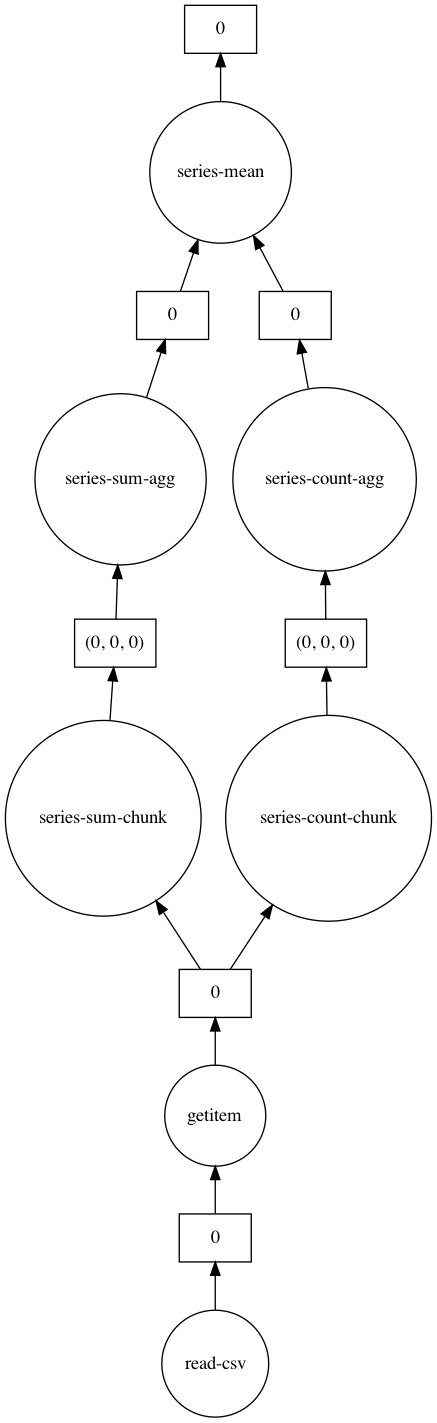

In [15]:
dask.visualize(avg_query_length)

## 4. Shut cluster down
To shut the cluster down, cancel the job that runs the cluster. Or you can shut the cluster and the experiments down in Azure portal.

In [16]:
for run in ws.experiments['dask_experiment2'].get_runs():
    if run.get_status() == "Running":
        print(f'cancelling run {run.id}')
        run.cancel()